<a href="https://colab.research.google.com/github/dkalenov/ML-Trading/blob/1_unsupervised-learning/Hidden_Markov_Models_for_Market_Regimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Case Study

Many strategies can be highly profitable depending on whether you are in an upward trending, downward trending or oscillating market. However, how can you tell what market you are in and in addition do this without an subjective bias?

Hidden Markov Model (HMM) is a statistical model used to model data sequences in which hidden (unobservable) states are present. HMM consists of two main components:

1. Hidden sequence of states: It is a sequence of states that we cannot observe directly. Each state affects the next observed variable and the next state.
2. Observable Variables: These are data that we can observe or measure. The observed variables depend on the current hidden state.

HMMs can be used for a variety of tasks, including time series analysis and forecasting. In the context of crypto market analysis, HMM can be used for state detection: identifying hidden states that will model price behavior. For example, states can be "uptrend", "downtrend" and "sideways".


**So Hidden Markov Models allow us to determine any number of states we like, given inputs such as returns and volatility (or any inputs of your choosing), to help ascertain what state - or regime - the market is in. This is part of a type of analysis known as Regime identification.**

### Useful Resources

HMM Colab Version with Backtest: https://colab.research.google.com/drive/12qzR8SrhfhQDBImKYQqUKdj6n60E9jNp?usp=sharing

### Imports

In [8]:
import pandas as pd
import numpy as np
!pip install pyhhmm
from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader

import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for pyhhmm: filename=pyhhmm-2.0.1-py3-none-any.whl size=35476 sha256=c5a688299434f70720811caa93841b2cd4d4d80337ed61c17c21d67e98f0cc52
  Stored in directory: /root/.cache/pip/wheels/ca/69/15/8982f3bd74e20bc98c02fbcaaac319525278ad9295410d5a41
Successfully built pyhhmm


### Data Management

In [9]:
# # Data Extraction
# start_date = "2017-01-1"
# end_date = "2022-06-1"
# symbol = "SPY"
# data = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
# data = data[["Open", "High", "Low", "Adj Close", "Volume"]]

In [10]:
import yfinance as yf

data = yf.download("BTC-USD", "2017-01-01", "2024-03-26")
data = data[["Open", "High", "Low", "Adj Close", "Volume"]]
data.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Adj Close,Volume
Date,,,,,
2024-03-21,67911.585938,68199.992188,64580.917969,65491.390625,44480350565
2024-03-22,65489.929688,66623.750000,62355.371094,63778.761719,41401116964
2024-03-23,63802.722656,65976.398438,63038.492188,64062.203125,24738964812
2024-03-24,64070.753906,67622.757812,63825.851562,67234.171875,27206630673
2024-03-25,67234.093750,71162.593750,66414.835938,69958.812500,42700139523


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2641 entries, 2017-01-01 to 2024-03-25
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2641 non-null   float64
 1   High       2641 non-null   float64
 2   Low        2641 non-null   float64
 3   Adj Close  2641 non-null   float64
 4   Volume     2641 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 123.8 KB


In [12]:
# Add Returns and Range
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head()

,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249


In [13]:
# Structure Data
X_train = df[["Returns", "Range"]]
X_train.head()

,Returns,Range
Date,,
2017-01-02,0.023464,0.034803
2017-01-03,0.021620,0.022005
2017-01-04,0.106233,0.110130
2017-01-05,-0.122410,0.308302
2017-01-06,-0.109711,0.184249


### HMM Learning

In [14]:
# Train Model
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(<pyhhmm.gaussian.GaussianHMM at 0x7f9fcd5b2fb0>, 11956.638293704857)

In [15]:
# Check Results
hidden_states = model.predict([X_train.values])[0]
print(hidden_states[:40])
len(hidden_states)

[0 2 3 1 1 1 3 2 0 1 1 3 2 0 2 3 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 0
 2 1 2]


2640

In [16]:
# Regime state means for each feature
model.means

array([[ 0.00880186,  0.02931752],
       [-0.03282149,  0.12042578],
       [-0.01279388,  0.03680991],
       [ 0.0470274 ,  0.07089013]])

In [17]:
# Regime state covars for each feature
model.covars

array([[[ 0.00024588,  0.00014049],
        [ 0.00014049,  0.00020501]],

       [[ 0.00356413, -0.00154216],
        [-0.00154216,  0.00452277]],

       [[ 0.00042034, -0.00029465],
        [-0.00029465,  0.00043133]],

       [[ 0.00144864,  0.00126566],
        [ 0.00126566,  0.00136648]]])

### Data Visualization

In [18]:
# Structure the prices for plotting
i = 0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
prices = df["Adj Close"].values.astype(float)
print("Correct number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
    i += 1

Correct number of rows:  True


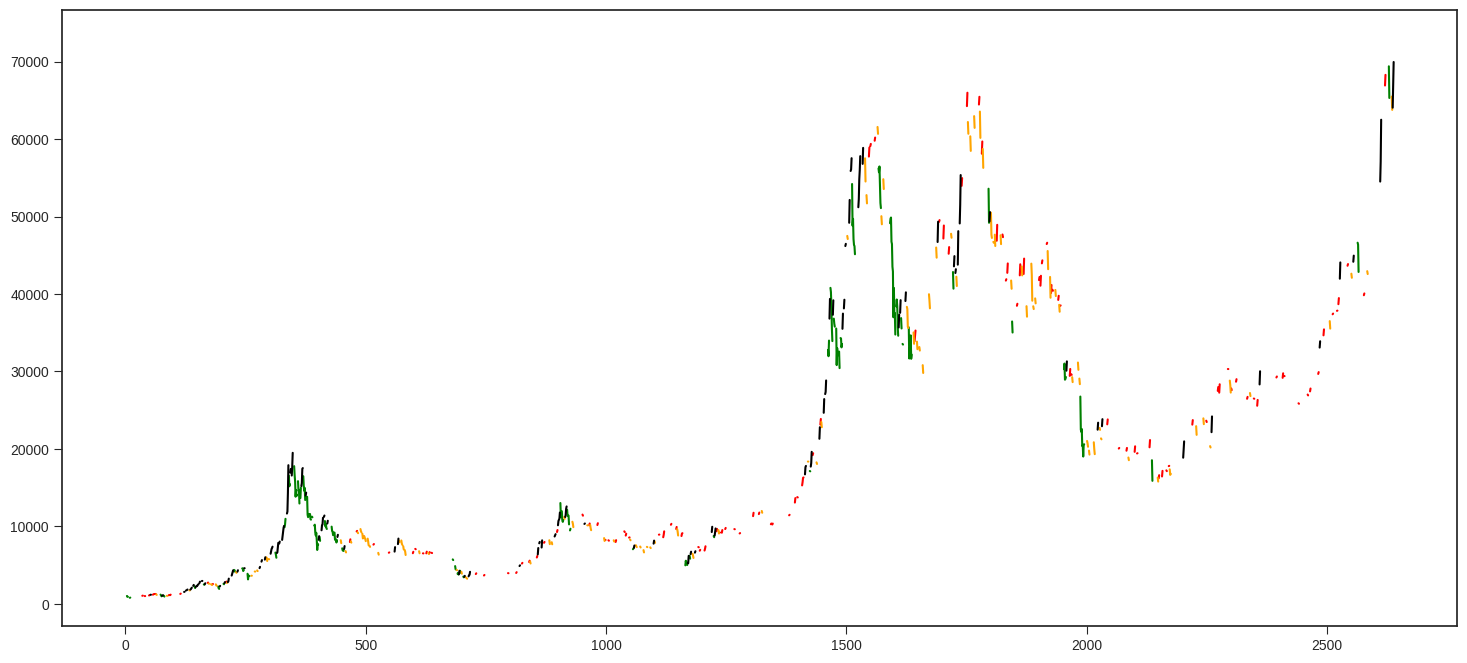

In [19]:
# Plot Chart
fig = plt.figure(figsize= (18, 8))
plt.plot(labels_0, color="red")
plt.plot(labels_1, color="green")
plt.plot(labels_2, color="orange")
plt.plot(labels_3, color="black")
plt.show()

The Hidden Markov Model is able to identify market regimes based on returns and volatility behaviour.

# Splitting

In [20]:
df.head()

,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249


In [21]:
# Add Returns and Range
print("Length: ", len(df))
df.head()

Length:  2640


,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249


In [22]:
# Add Moving Average
df["MA_12"] = df["Adj Close"].rolling(window=12).mean()
df["MA_21"] = df["Adj Close"].rolling(window=21).mean()

In [23]:
# Structure Data
X_train = df[["Returns", "Range"]].iloc[:1500]
X_test = df[["Returns", "Range"]].iloc[1500:]
save_df = df.iloc[1500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  1500
Test Length:  1140
X_train From:  2017-01-02 00:00:00
X_train To:  2021-02-09 00:00:00
X_test From:  2021-02-10 00:00:00
X_test To:  2024-03-25 00:00:00


# Train HMM

In [24]:
# Train HMM
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])
model.predict([X_train.values])[0][:10]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 0, 3, 2, 2, 2, 0, 1, 0, 2], dtype=int32)

In [25]:
# Make Prediction on Test Data
df_main = save_df.copy()
df_main.drop(columns=["High", "Low"], inplace=True)

hmm_results = model.predict([X_test.values])[0]
df_main["HMM"] = hmm_results
df_main.head()

,Open,Adj Close,Volume,Returns,Range,MA_12,MA_21,HMM
Date,,,,,,,,
2021-02-10,46469.761719,44918.183594,87301089896,-0.033625,0.074392,38728.251628,36003.751209,1
2021-02-11,44898.710938,47909.332031,81388911810,0.066591,0.096762,39864.902344,36817.257533,3
2021-02-12,47877.035156,47504.851562,76555041196,-0.008443,0.049989,41064.110026,37507.690383,1
2021-02-13,47491.203125,47105.515625,70250456155,-0.008406,0.035684,42194.805013,38223.779576,0
2021-02-14,47114.507812,48717.289062,71248675228,0.034216,0.050369,43295.388346,39006.061012,3


# Run Backtest

In [149]:
# Add MA Signals
df_main.loc[df_main["MA_12"] > df_main["MA_21"], "MA_Signal"] = 1
df_main.loc[df_main["MA_12"] <= df_main["MA_21"], "MA_Signal"] = 0

In [150]:
# Add HMM Signals
favourable_states = [1] #  Change to check. E.g. if 0 - we do MA Signals only if HMM Signals=0  // [0, 1, 2, 3]
hmm_values = df_main["HMM"].values
hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
df_main["HMM_Signal"] = hmm_values

In [151]:
# Add Combined Signal
df_main["Main_Signal"] = 0
df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1
df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [152]:
# Benchmark Returns
df_main["lrets_bench"] = np.log(df_main["Adj Close"] / df_main["Adj Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exp"] = np.exp(df_main["bench_prod"]) - 1

In [153]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exp"] = np.exp(df_main["lrets_prod"]) - 1

In [154]:
# Review Results Table
df_main.dropna(inplace=True)
df_main.tail()

,Open,Adj Close,Volume,Returns,Range,MA_12,MA_21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2024-03-10,68500.257812,69019.789062,35683977532,0.007605,0.025868,65193.640951,59770.282180,0,1.0,0,1.0,0.007576,0.207266,0.230310,0.007567,0.711792,1.037640
2024-03-11,69020.546875,72123.906250,65716656765,0.044974,0.084171,65995.234049,60739.080357,3,1.0,0,0.0,0.043992,0.251258,0.285642,0.000000,0.711792,1.037640
2024-03-12,72125.125000,71481.289062,62554434520,-0.008910,0.059608,66852.142904,61653.195312,1,1.0,1,0.0,-0.008950,0.242308,0.274187,-0.000000,0.711792,1.037640
2024-03-13,71482.117188,73083.500000,48212536929,0.022414,0.032290,67739.048503,62664.829613,0,1.0,0,1.0,0.022167,0.264475,0.302747,0.022099,0.733891,1.083171
2024-03-14,73079.375000,71396.593750,59594605698,-0.023082,0.075654,68519.610677,63621.573475,1,1.0,1,0.0,-0.023352,0.241123,0.272677,-0.000000,0.733891,1.083171


# Calculate Metrics

In [156]:
# Sharpe Ratio Function
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01 # can be changed to 2 or 3 % over that is not ok
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [157]:
# Metrics
bench_rets = round(df_main["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_main["strat_prod_exp"].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_main["lrets_strat"].values)

In [158]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%") # this value represents the percentage return for the Benchmark
print(f"Returns Strategy: {strat_rets}%") # this value represents the percentage return for the Strategy
print("---- " * 5)
print(f"Sharpe Benchmark: {bench_sharpe}") # How much we get back for every dollar risk taken (0.15: for taking risk 1 $ can get 15 cents back)
print(f"Sharpe Strategy: {strat_sharpe}") # How much we get back for every dollar risk taken (0.15: for taking risk 1 $ can get 15 cents back)

Returns Benchmark: 27.3%
Returns Strategy: 108.3%
---- ---- ---- ---- ---- 
Sharpe Benchmark: 0.09
Sharpe Strategy: 1.01


### Plot Results

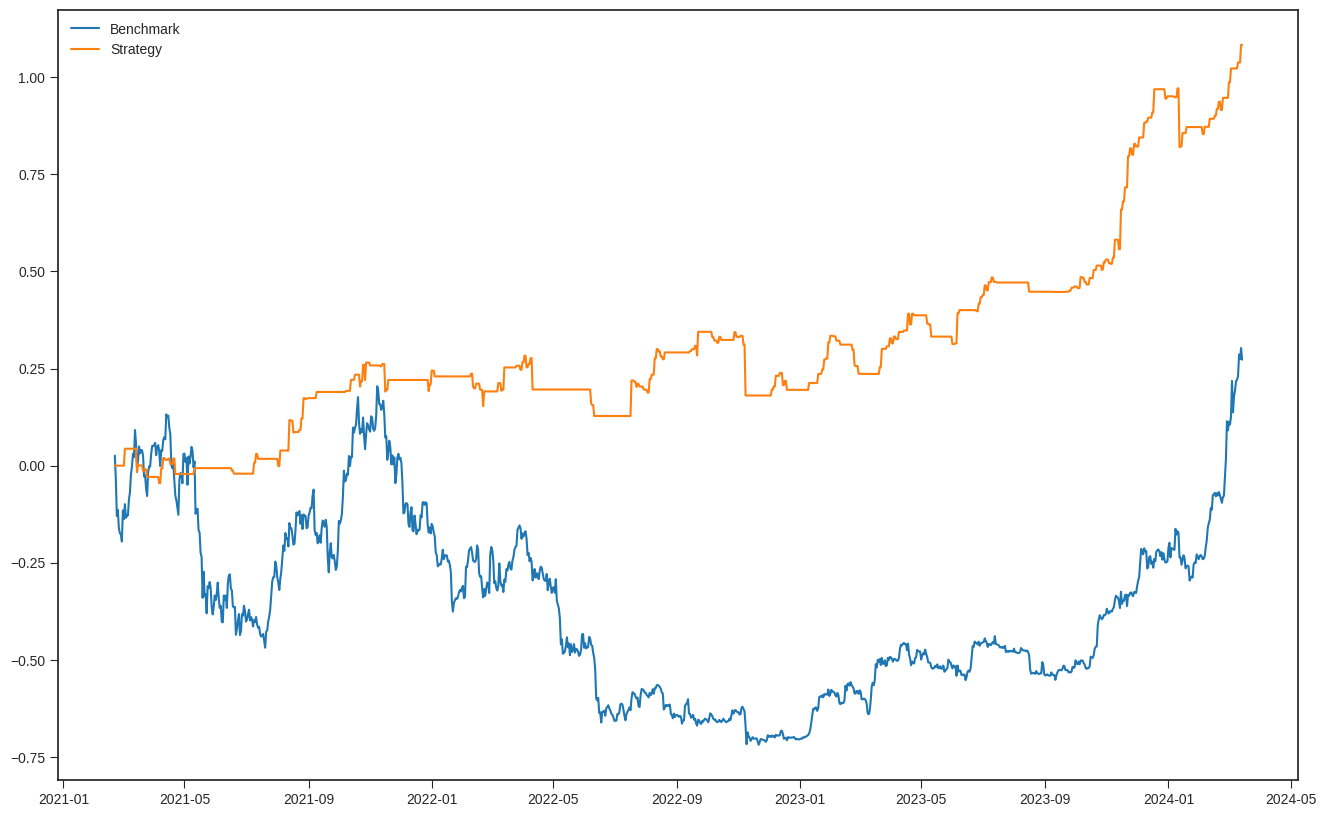

In [159]:
# Plot Equity Curves
fig = plt.figure(figsize = (16, 10))
plt.plot(df_main["bench_prod_exp"], label="Benchmark")
plt.plot(df_main["strat_prod_exp"], label="Strategy")
plt.legend()
plt.show()

# Save Data

In [144]:
# Save Data
import os

if not os.path.exists('data'):
    os.makedirs('data')

df_main.to_csv("data/HMM-SPY.csv", index=False)